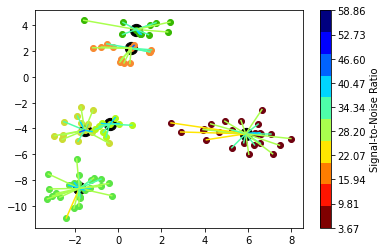

0.874849796295166
{'Cluster Head': 'client7', 'Members': ['client13', 'client19', 'client25', 'client43', 'client53', 'client60', 'client63', 'client84'], 'SNR': [33.645770784789256, 36.62850209220935, 36.6199886738333, 32.89540088915, 30.184384721259935, 30.14850949725037, 34.904693629165756, 33.1614290079287], 'CSI': [0.9040418445783387, 0.5713141624375432, 0.055089756968146664, 0.11748588498430435, 0.9167894004528232, 0.8421967647908827, 0.6378336434304378, 0.009789149006938391]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=4

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
#                 params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        client_temp=copy.deepcopy(client)
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client_temp['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client_temp['model'].conv1.weight.data=data
        
        
        
        data=client_temp['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client_temp['model'].conv2.weight.data=data
        
        distorted_models.append(client_temp)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300442


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access 

Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305377
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272780

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365306


/tmp/ipykernel_130347/2319741324.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312940
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.256563

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253358
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292413
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299694

Power Allocated= 4.512659367375423
CSI= 0.2445734493102375
SNR= 28.747257133297587
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.336953
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272243
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301146

Power Allocated= 7.539542518164425
CSI= 0.9417365373249347
SNR= 43.67771495370014
Client: client22
Model client22 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310885
Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279367
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287416

Power Allocated= 7.519424502515247
CSI= 0.924226

ROUND 0
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303096
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300257
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280707

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299337
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302434
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295072

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295741
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297914
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.

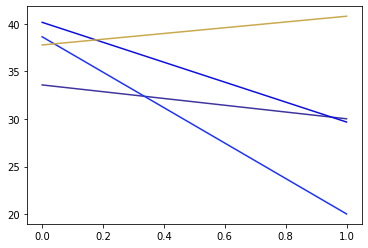

ROUND 1
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300821
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294346
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295833

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302879
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299008
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285672

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301160
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297166
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.

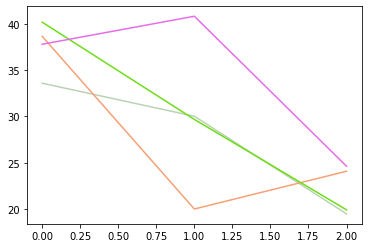

ROUND 2
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301950
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291625
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261097

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298887
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293539
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.278471

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303035
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287993
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.

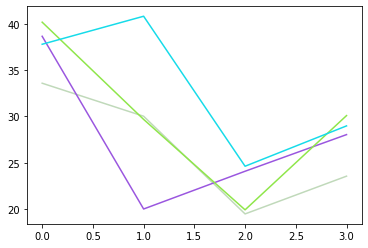

ROUND 3
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304310
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277239
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.037061

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298093
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285757
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.136423

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303846
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280377
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.

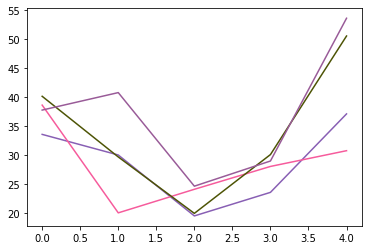

ROUND 4
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291048
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.189423
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.856766

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287985
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.002746
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.507526

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289537
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.222413
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

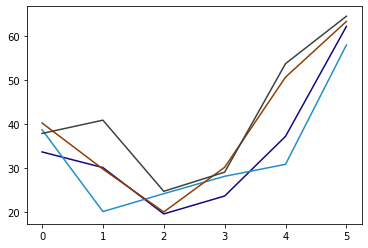

ROUND 5
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269707
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.124975
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.745202

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264210
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.133858
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.686068

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264987
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.072526
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

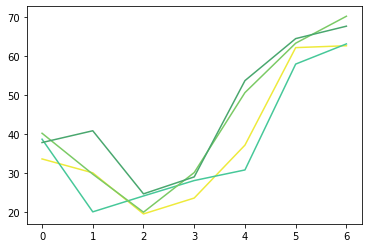

ROUND 6
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280156
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.158942
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.996703

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274504
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.987381
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.493292

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269699
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.949836
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

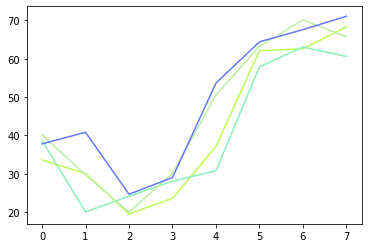

ROUND 7
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286049
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.187485
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.741951

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281801
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.172579
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.503188

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.279640
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.141050
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

ROUND 8
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274482
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.931863
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.559224

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256835
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.961851
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.475058

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277337
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.908188
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

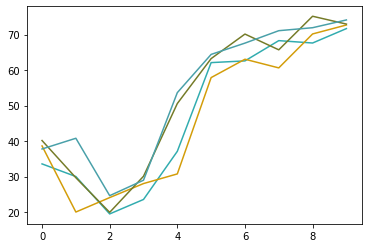

ROUND 9
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272081
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.029449
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.698836

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251110
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.925223
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.309018

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233611
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.075303
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.

ROUND 10
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276173
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.932197
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.352942

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226482
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.665566
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.298272

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223530
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.034763
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

ROUND 11
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.207189
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.862855
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.479311

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.184926
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.975458
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.482414

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208253
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.652860
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

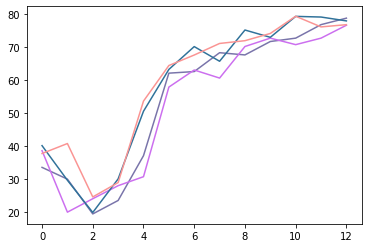

ROUND 12
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219638
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.635204
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.185350

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190546
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.564949
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.124214

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.185897
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.870787
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

ROUND 13
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198076
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.716554
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.752741

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.133148
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.670269
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.270229

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.174743
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.602733
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

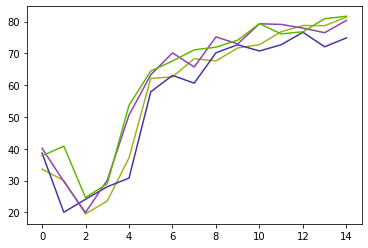

ROUND 14
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.201201
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.811038
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.156943

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.116226
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.244964
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.079153

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.129919
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.626210
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

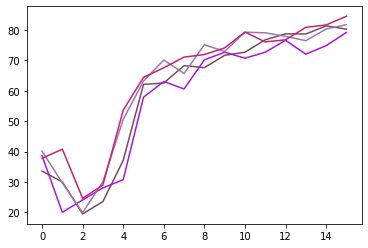

ROUND 15
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.084800
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.473294
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.180253

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.106325
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.565277
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.100016

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.069815
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.354066
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

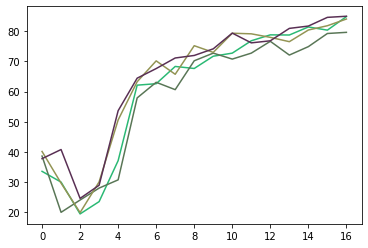

ROUND 16
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.097646
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.401393
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.560576

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.007375
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.196383
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.082577

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.047763
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.233761
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

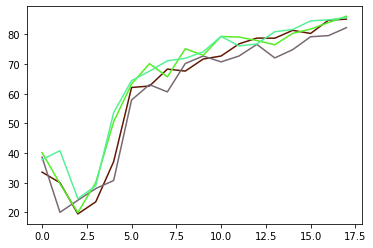

ROUND 17
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.982107
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.319324
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.903104

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.982590
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.259017
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.041247

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.966537
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.189038
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

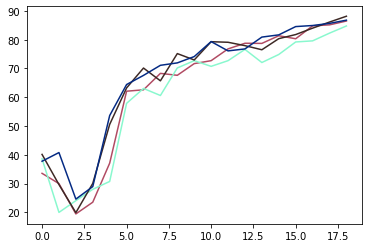

ROUND 18
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.986981
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.226980
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141967

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.918499
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.103039
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.426792

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.954079
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.008365
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 19
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.930663
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.213903
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.915846

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.930123
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.190145
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.820627

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.868007
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.450340
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 20
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.913925
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.044531
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.412357

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.863556
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.000392
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.099602

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.897551
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.836073
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

ROUND 21
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.907501
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.986850
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.008128

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.847282
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.202763
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.951957

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.782483
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.098613
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

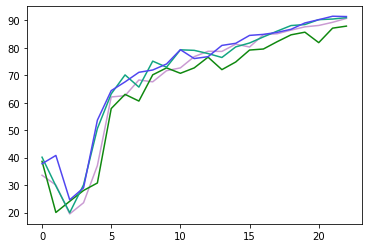

ROUND 22
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.693509
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.887782
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.893171

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.712063
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.861547
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.068137

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.809815
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.909948
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

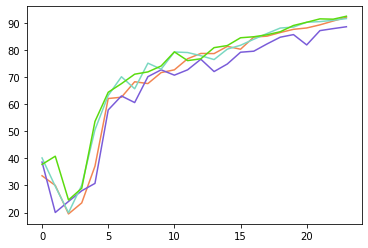

ROUND 23
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.688603
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.758064
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.060424

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.666818
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.711889
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.224664

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.616674
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.843954
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

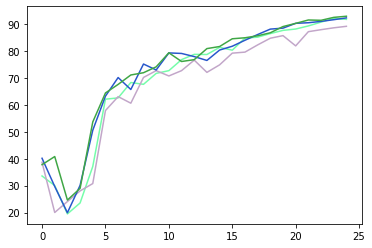

ROUND 24
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.660960
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.603355
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452211

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.667809
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.780362
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.807982

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.619595
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.873597
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

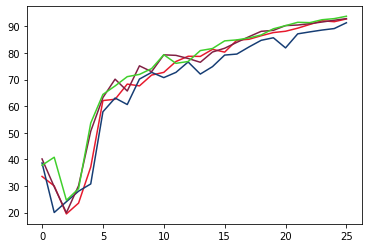

ROUND 25
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.808821
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.800320
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.499275

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.504473
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.609183
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.767554

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.554206
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.679215
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

ROUND 26
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.803896
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.689243
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.797182

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.372801
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.596970
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.068691

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.475588
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.515428
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 27
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.374015
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.488733
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678487

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.350294
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364211
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.609837

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.373887
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.512050
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

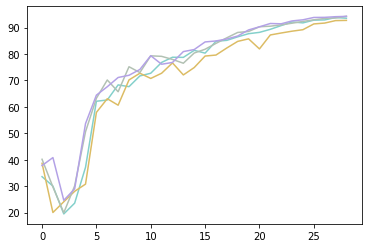

ROUND 28
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.392123
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.728206
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359415

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.238722
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332899
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.738902

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.397256
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.454400
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

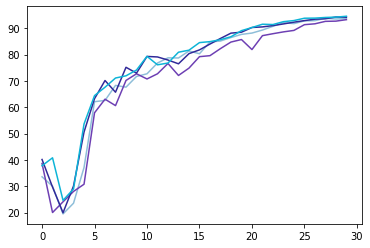

ROUND 29
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.358933
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367119
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.698910

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.296770
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467465
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.947564

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.267560
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.587640
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

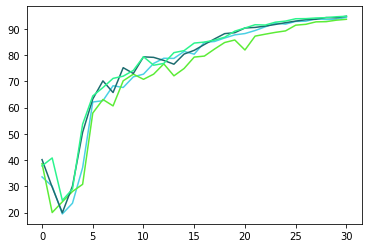

ROUND 30
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.107246
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443231
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426302

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.217431
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.593669
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.380999

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.232353
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.269836
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

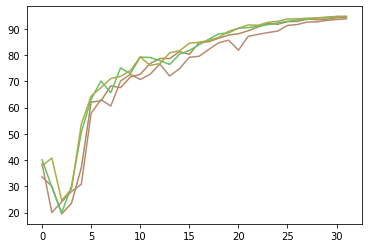

ROUND 31
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.270600
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.676030
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.489186

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.188298
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.560102
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220955

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.263232
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463047
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

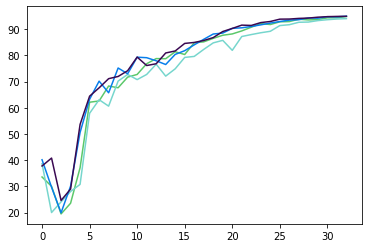

ROUND 32
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.161489
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.590262
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.571303

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.079373
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245053
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.178392

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.120187
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.398293
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 33
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.288411
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.676475
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.904076

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.150322
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.474028
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176652

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.039399
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219190
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

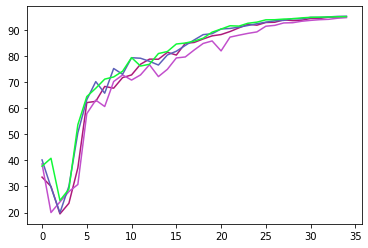

ROUND 34
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.148804
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.491838
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.730880

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.139787
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.422995
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.578010

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.189743
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.528549
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

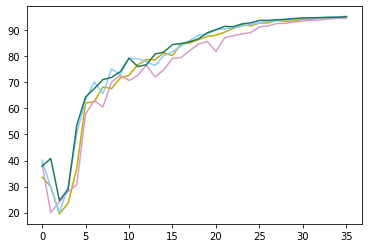

ROUND 35
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.184544
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313752
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520344

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.198980
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218798
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.722322

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.118107
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.413859
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 36
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.354482
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278987
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417871

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017907
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243769
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399751

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.148493
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184607
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

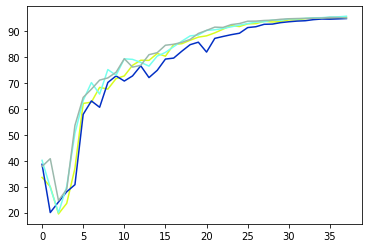

ROUND 37
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.067780
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227524
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.462373

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.122159
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306316
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.502088

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.044626
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.384960
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

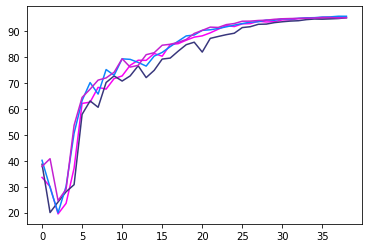

ROUND 38
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.980199
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.471348
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.654141

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860204
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.373622
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.535005

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969326
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.638318
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

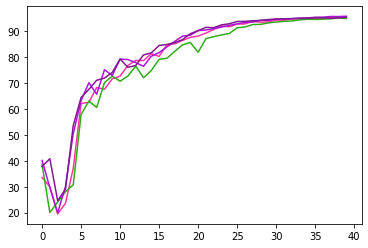

ROUND 39
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874396
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362502
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205994

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917686
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.422567
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.765404

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.014807
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243895
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

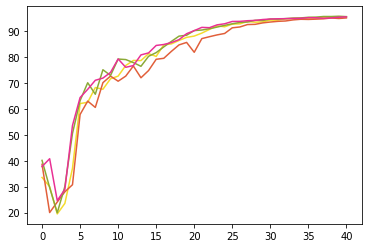

ROUND 40
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.092770
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258016
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359078

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.862222
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379652
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.860855

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.997644
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334747
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

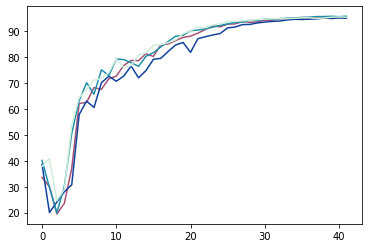

ROUND 41
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911477
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102098
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.530327

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.952207
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242290
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.593111

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946493
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264809
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

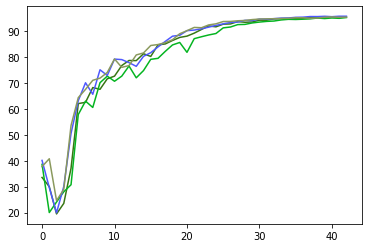

ROUND 42
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.153810
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285344
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.894302

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.774881
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167523
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102834

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.000221
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.384271
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

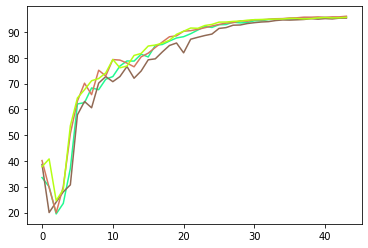

ROUND 43
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.861273
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.270301
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449736

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004219
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.394210
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203771

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.851084
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171110
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 44
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.054736
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283442
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.715405

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.888079
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362944
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426130

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.856875
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.471062
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

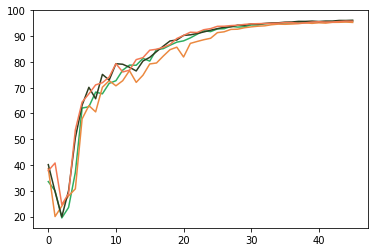

ROUND 45
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.913151
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174968
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.542747

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917957
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255282
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220884

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877491
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.464948
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 46
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.906089
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.525777
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.495650

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.811970
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170027
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.508957

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.907466
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157882
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

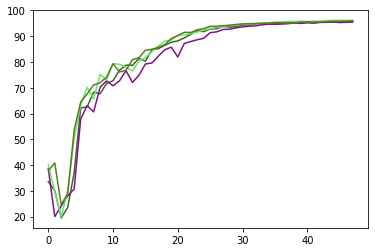

ROUND 47
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767974
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212588
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198250

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.820341
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.444312
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183915

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747138
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266853
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

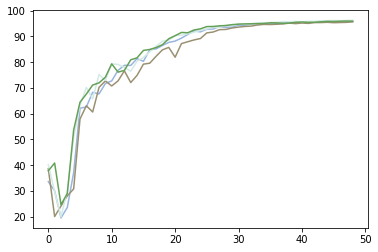

ROUND 48
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.894368
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257998
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.195782

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.863470
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225633
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.478930

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855490
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.327069
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

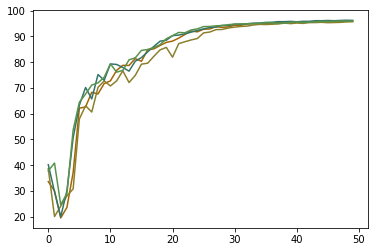

ROUND 49
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884262
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.522430
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247134

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.865486
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298372
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704043

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.732486
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241146
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

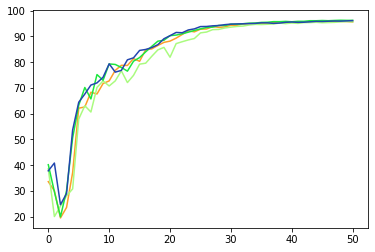

ROUND 50
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.924713
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279184
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.024075

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.680515
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.644306
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374592

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798472
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215639
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

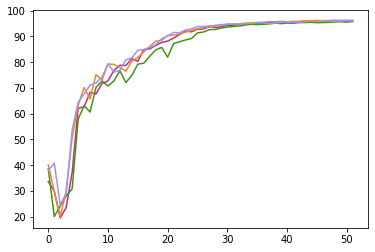

ROUND 51
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.694839
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214575
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656773

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.726846
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040140
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149410

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.702189
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279364
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

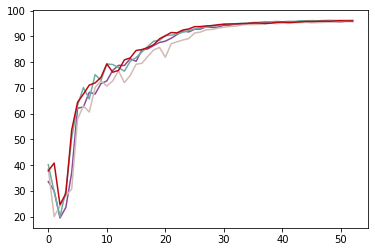

ROUND 52
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.831523
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114801
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247358

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807547
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.381164
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.476885

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780533
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268735
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

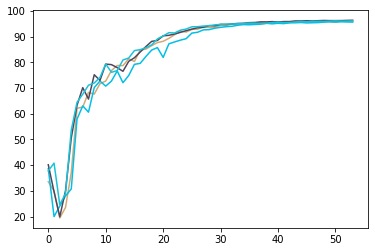

ROUND 53
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703948
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070411
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496276

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693583
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102467
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.563832

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712929
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.448237
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

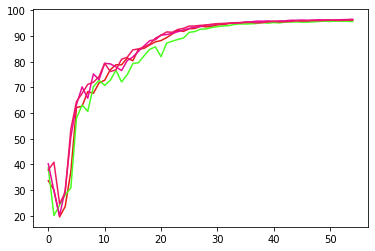

ROUND 54
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850278
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222386
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.532102

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.655391
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245151
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219923

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688553
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251801
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

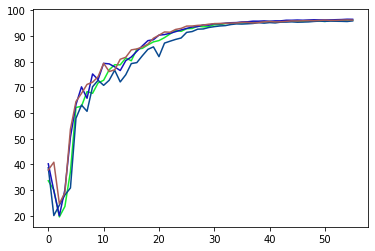

ROUND 55
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.533148
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304100
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221399

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690358
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118332
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.698736

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.636485
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084240
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

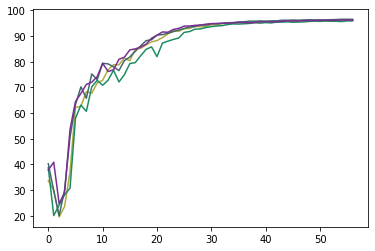

ROUND 56
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678824
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281500
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405877

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731175
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173119
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238406

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673992
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272175
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

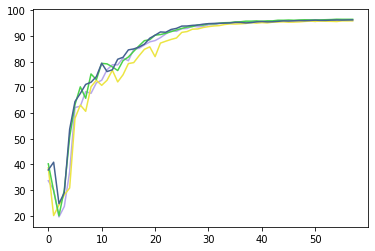

ROUND 57
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.023613
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.342142
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.451800

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750822
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234368
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305833

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782090
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193579
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

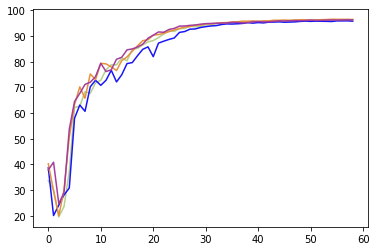

ROUND 58
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.082987
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161592
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.547642

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.868086
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248235
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294134

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.921502
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.432871
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

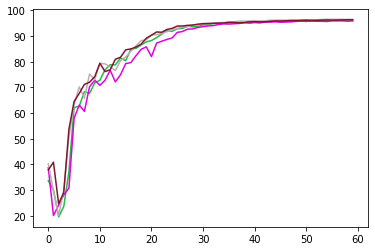

ROUND 59
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944422
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185463
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096457

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609485
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161322
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.989139

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760240
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337560
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

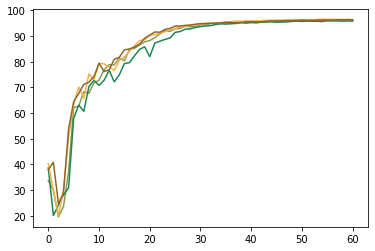

ROUND 60
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.972191
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268727
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.270466

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569580
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.322753
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.490071

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.675263
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175349
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

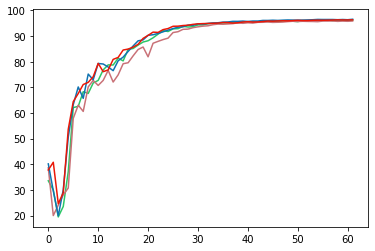

ROUND 61
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827152
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189355
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330396

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.787295
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181836
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.338773

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.561061
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234276
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

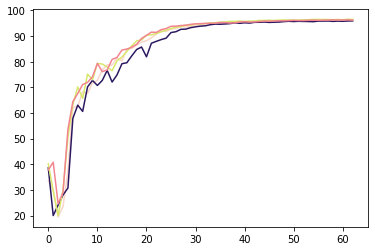

ROUND 62
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.758591
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172027
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.332380

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644282
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067725
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.573504

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536671
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171585
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

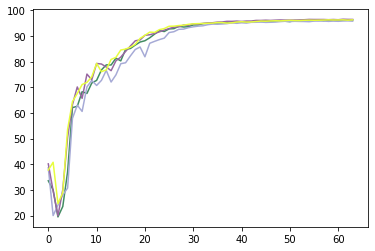

ROUND 63
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.799919
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.423729
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220357

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.704966
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160995
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230746

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.823347
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220470
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

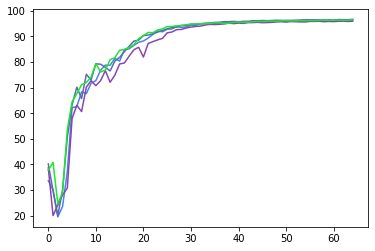

ROUND 64
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.735199
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224583
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.423035

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795821
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079098
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.816362

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.724001
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184788
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

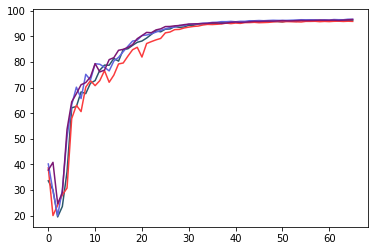

ROUND 65
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.737275
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239356
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.516419

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629330
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217063
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230136

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.742087
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166846
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

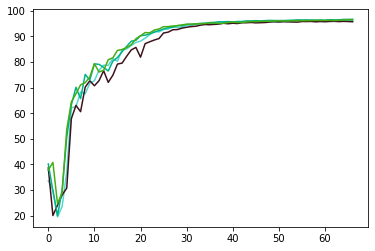

ROUND 66
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.815457
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306801
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.031858

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657410
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171960
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237048

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.787762
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151276
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

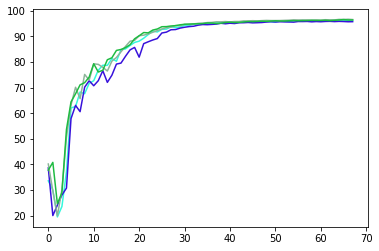

ROUND 67
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.776904
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205509
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129407

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.638435
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178329
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543015

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678142
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441858
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

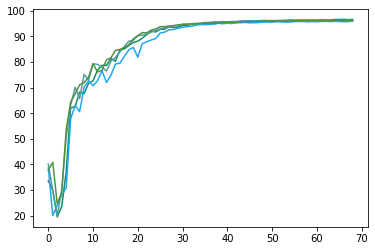

ROUND 68
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629769
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279890
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399798

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522968
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.721956
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.345116

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.641522
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126034
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

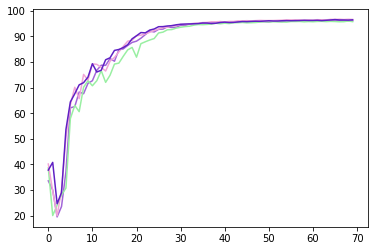

ROUND 69
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.706743
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315414
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.966615

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.756896
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195025
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374979

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616414
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.305595
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

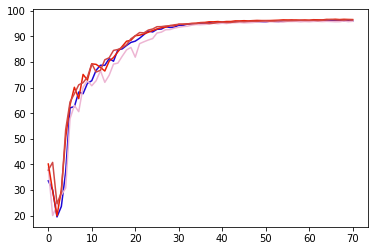

ROUND 70
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.813424
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294600
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123160

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631563
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113165
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.303152

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.713785
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052933
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

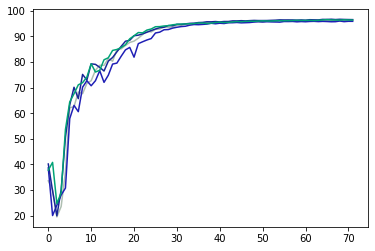

ROUND 71
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721140
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123860
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134069

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.677164
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163067
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.548175

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676307
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260969
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

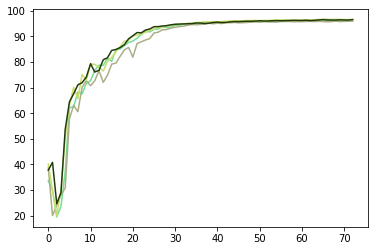

ROUND 72
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778057
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104140
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190142

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.746001
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163362
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.613436

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.671749
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094985
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

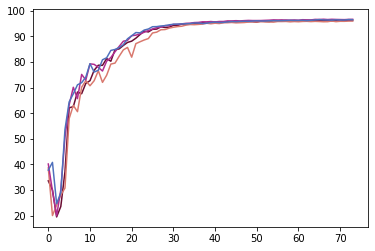

ROUND 73
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513712
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164142
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154353

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621947
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155686
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157482

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.675607
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307817
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

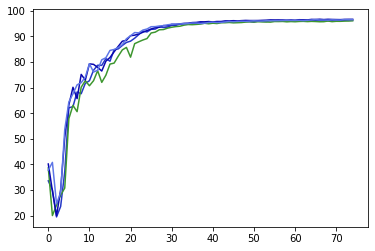

ROUND 74
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467782
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085653
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251727

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.670425
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181177
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.479885

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614849
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138386
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

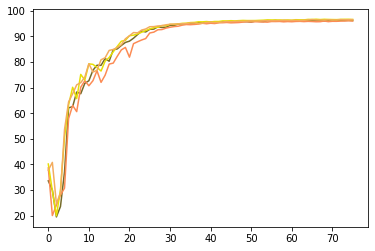

ROUND 75
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631064
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121023
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.340735

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.557386
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262339
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232142

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536854
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101432
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

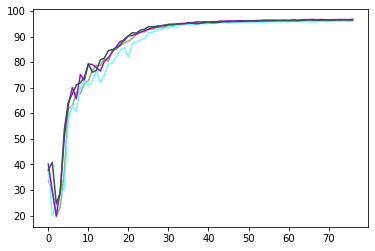

ROUND 76
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.755770
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263961
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405655

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.601604
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256168
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269856

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587120
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.491502
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

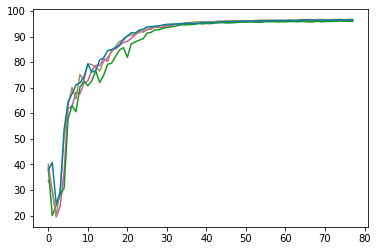

ROUND 77
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985233
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241462
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.457940

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678426
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191387
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.450954

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632830
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163022
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 78
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720779
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098365
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390019

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528373
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256824
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361770

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672850
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237902
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

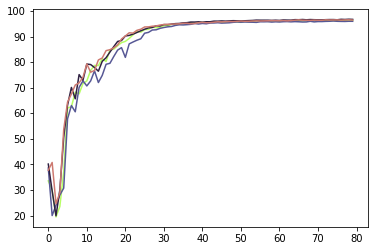

ROUND 79
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722096
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114255
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.325779

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613000
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106887
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330097

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575663
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103555
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 80
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543251
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098058
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.308999

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512182
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087511
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099354

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667040
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168024
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

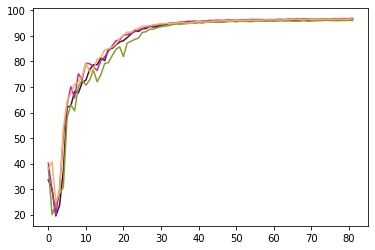

ROUND 81
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634855
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138784
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496752

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.577690
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121224
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.615397

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646325
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182530
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

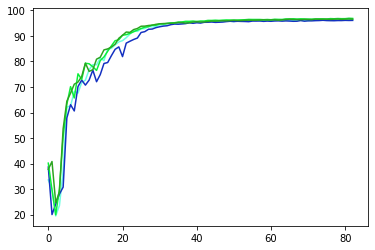

ROUND 82
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657422
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080830
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.414980

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.607403
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102978
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.010038

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647234
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328010
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 83
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734475
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.378998
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249276

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.668449
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102893
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218060

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543444
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196737
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

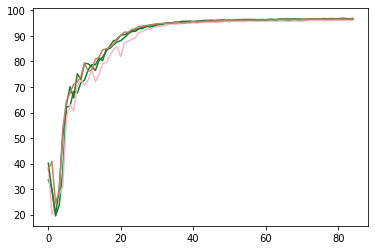

ROUND 84
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527317
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070750
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.260292

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.608861
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139225
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071487

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780656
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147265
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

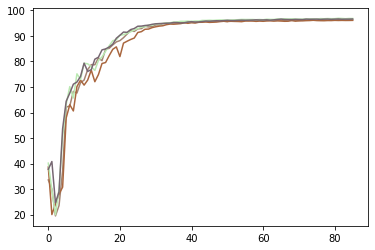

ROUND 85
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.618792
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068831
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251866

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623194
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203240
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151903

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563288
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109346
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

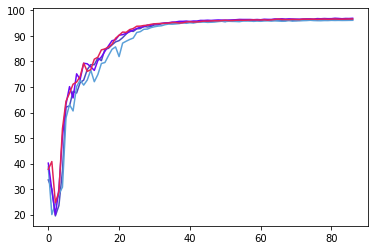

ROUND 86
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.519232
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093742
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066145

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662900
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101467
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.338496

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.552786
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220815
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 87
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.715616
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172372
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110785

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.708967
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180618
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137073

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.495275
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084737
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

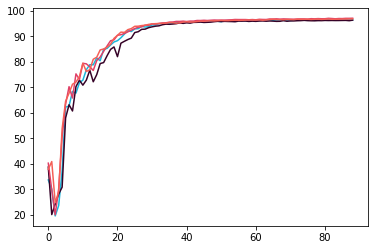

ROUND 88
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595383
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071199
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038428

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712334
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317171
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591124

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.517583
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137751
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

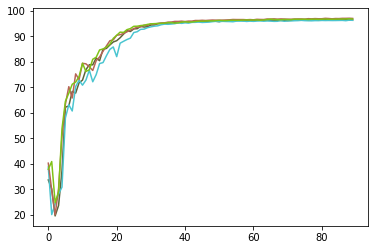

ROUND 89
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.648463
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039571
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144832

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548919
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113517
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275093

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497137
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156283
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

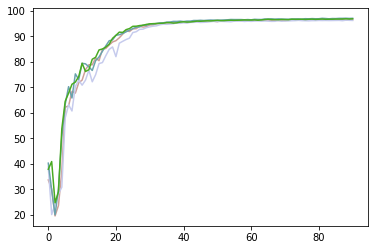

ROUND 90
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802549
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211272
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059275

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507651
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298291
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079520

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515958
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315143
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

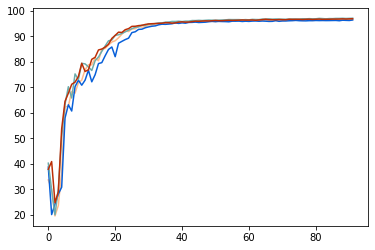

ROUND 91
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.635153
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226074
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273914

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.565008
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261331
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015520

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530135
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203373
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

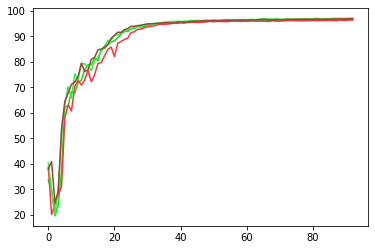

ROUND 92
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750095
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179433
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239557

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622743
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203704
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138417

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530268
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.466418
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

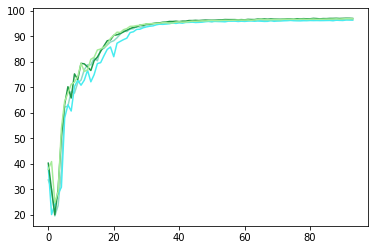

ROUND 93
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548874
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309347
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200433

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511011
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058345
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179899

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.635899
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152816
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 94
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.655165
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146546
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.665327

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473356
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.459369
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.770379

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570509
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076446
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 95
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.812696
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235792
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114770

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.643661
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277302
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.903426

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563501
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186057
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

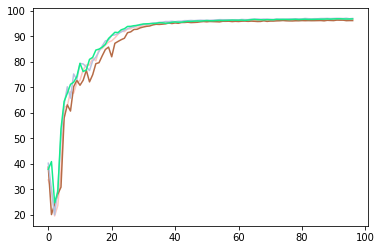

ROUND 96
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747930
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242201
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285810

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535993
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.340552
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.427097

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596364
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074397
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 97
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548721
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113112
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323860

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494468
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200137
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398693

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620571
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251145
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 98
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.607555
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183610
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.572021

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.545563
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164623
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.807380

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487050
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321811
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

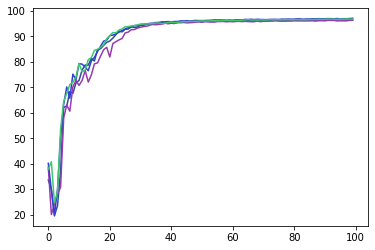

ROUND 99
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451958
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079242
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198848

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466254
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291210
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.281959

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505034
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129926
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

ROUND 100
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483036
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130117
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132361

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.612764
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187020
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.708752

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596192
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041033
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

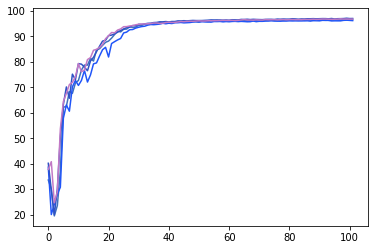

ROUND 101
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507506
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330496
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172160

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527425
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169784
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273416

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354474
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068370
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

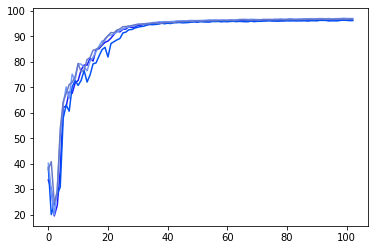

ROUND 102
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.724735
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149040
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099679

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.617523
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414490
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.547065

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.486971
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164995
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 103
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.841020
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051863
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207911

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.572644
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110702
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202307

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.559617
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156791
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 104
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.627756
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105431
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.738410

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.565452
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196175
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.136919

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535134
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121569
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

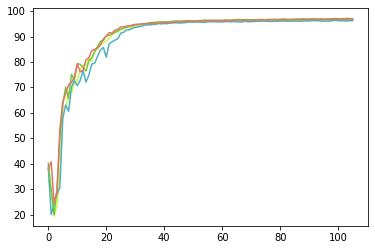

ROUND 105
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569795
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204769
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321523

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492498
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120297
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.612803

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498477
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107989
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

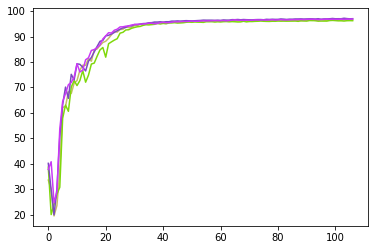

ROUND 106
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.949847
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261928
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681276

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470116
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024692
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109400

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551122
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129801
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

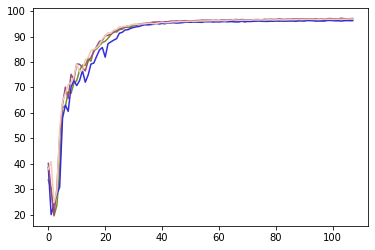

ROUND 107
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.838970
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053079
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180051

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.538146
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055118
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050458

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470592
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210832
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

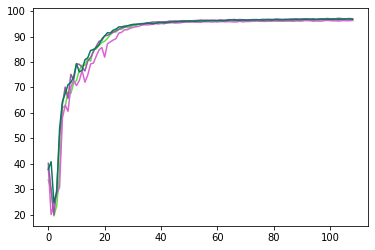

ROUND 108
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.935124
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149530
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055069

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.454360
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064040
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072294

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509438
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172520
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

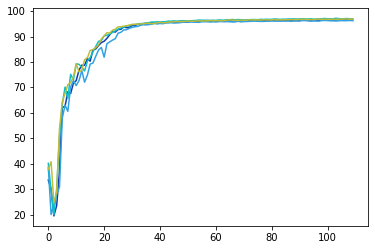

ROUND 109
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548241
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.433486
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333539

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537359
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239511
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.380091

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483542
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.259389
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

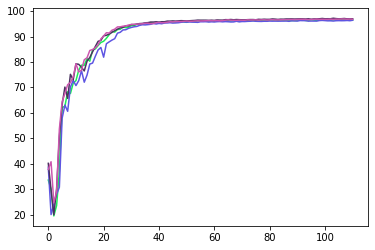

ROUND 110
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531403
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180371
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213827

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502592
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.252042
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119166

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.612750
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118388
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

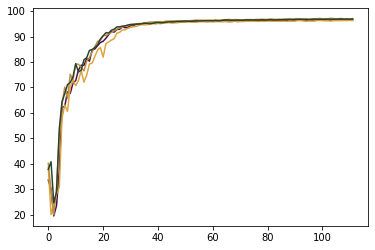

ROUND 111
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614932
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220374
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187811

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.365223
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153950
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142468

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456539
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165466
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

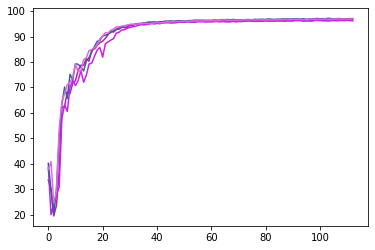

ROUND 112
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487591
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180051
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.876000

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472396
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049658
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026357

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435442
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084354
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 113
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492558
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.269734
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.453941

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509781
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151910
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.392895

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.450623
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218392
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

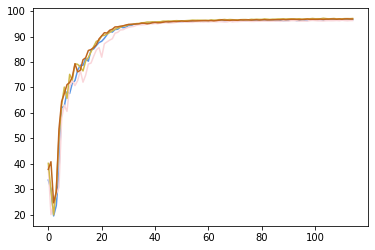

ROUND 114
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359787
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027441
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.516813

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406099
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088979
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.540021

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417983
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283729
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

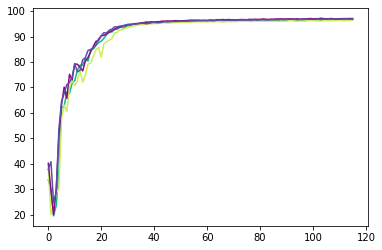

ROUND 115
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534203
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137324
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117735

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.420310
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277469
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.745949

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622001
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122766
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

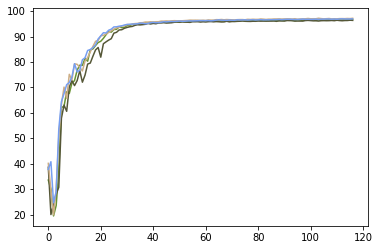

ROUND 116
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590305
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133126
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.534815

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470491
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148432
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333689

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513575
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218001
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

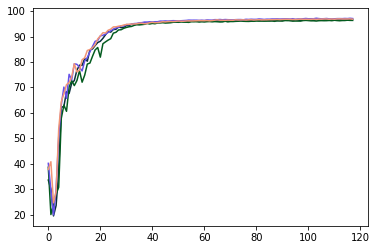

ROUND 117
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399829
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112410
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.258364

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353814
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079779
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.590610

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440128
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233342
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

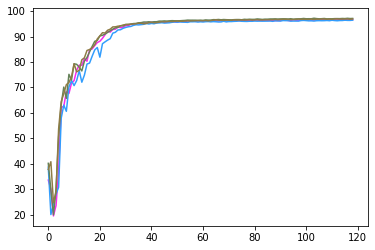

ROUND 118
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522234
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145773
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062667

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455360
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323751
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092476

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455939
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231784
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

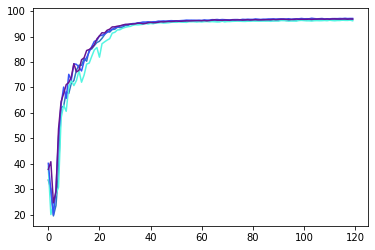

ROUND 119
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614146
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082007
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102535

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460607
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130570
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.714003

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.479931
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047173
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

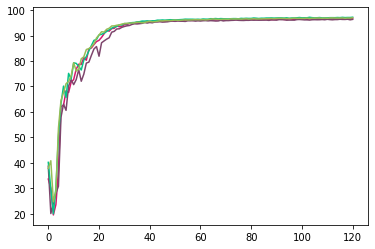

ROUND 120
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445942
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060694
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078220

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.597740
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106598
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063412

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588144
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075478
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

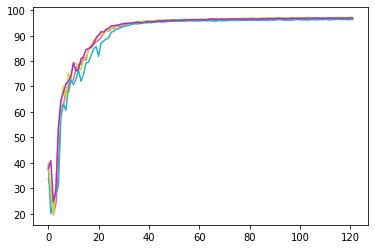

ROUND 121
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.480187
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157905
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248342

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426158
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174194
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.394732

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622576
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215188
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

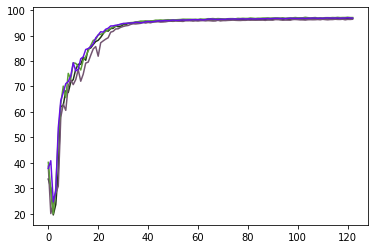

ROUND 122
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.465187
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084246
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.356628

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411925
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080348
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076695

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.524352
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280690
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 123
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.554796
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139956
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314269

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457918
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225269
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.582182

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513368
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055549
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 124
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499337
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.434789
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294344

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.318440
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096168
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180972

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428367
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086515
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

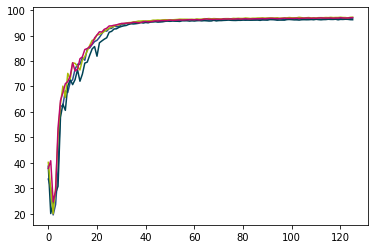

ROUND 125
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676434
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294196
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.893172

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603441
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029383
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113223

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588836
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070301
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

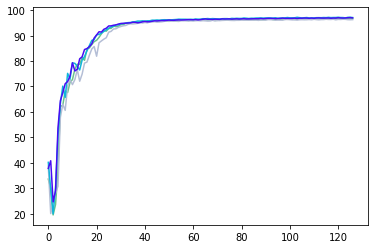

ROUND 126
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.601197
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.404842
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.554093

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427808
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104987
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101656

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575727
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083759
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

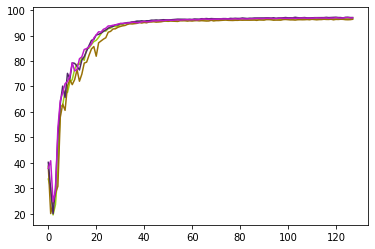

ROUND 127
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449178
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139370
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.997760

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.486737
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072822
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208663

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461109
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073177
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

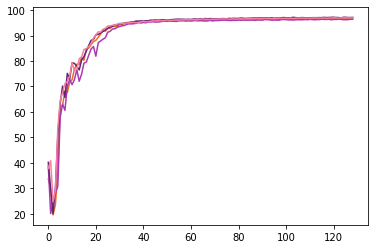

ROUND 128
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543857
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084217
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.188481

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316659
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007161
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.454151

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435350
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031531
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

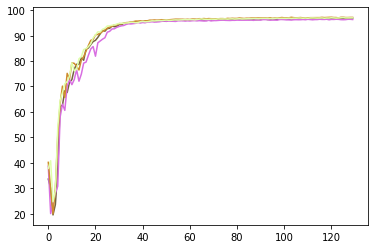

ROUND 129
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610236
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048741
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.257629

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522476
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046108
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078100

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.539029
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045562
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

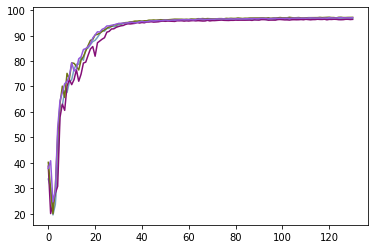

ROUND 130
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415555
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117315
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.447019

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531908
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107579
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062970

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484644
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405080
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 131
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548097
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057339
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.536111

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273723
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037358
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247555

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340780
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151039
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

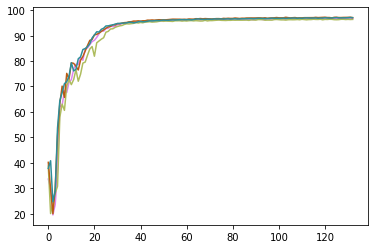

ROUND 132
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402362
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121074
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426510

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469567
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138059
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.260963

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562034
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029679
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

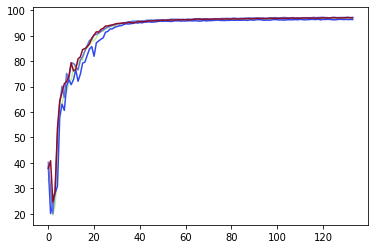

ROUND 133
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521908
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142153
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182013

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455387
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070255
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.432778

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440360
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155996
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 134
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.689051
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118919
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.343396

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489782
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147899
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262546

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.429381
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137139
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

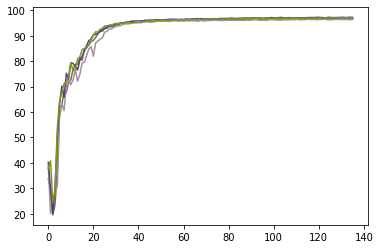

ROUND 135
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.524833
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035365
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181513

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482864
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070043
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012150

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490221
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203540
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

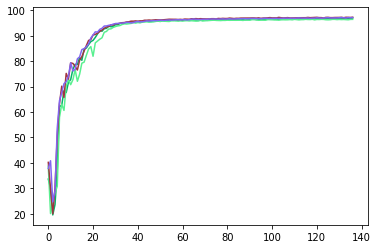

ROUND 136
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410883
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067754
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158392

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468516
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169330
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089268

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.501292
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256531
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 137
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431977
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072341
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193415

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449405
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179980
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191294

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406654
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199367
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

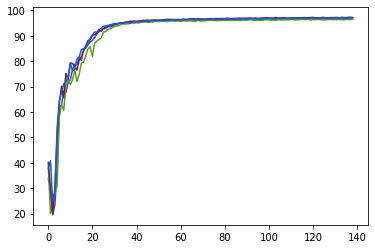

ROUND 138
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593690
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052290
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.380451

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470375
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145826
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060434

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.312907
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147217
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 139
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649371
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102637
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145604

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393280
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154920
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239539

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427892
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089763
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 140
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366501
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079499
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.296749

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.495652
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101772
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100095

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384511
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.372436
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 141
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471581
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071531
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208972

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.545249
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045439
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.271837

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452858
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074285
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

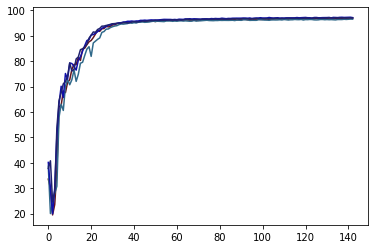

ROUND 142
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596883
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104484
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335611

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335201
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055580
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286282

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442350
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085868
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

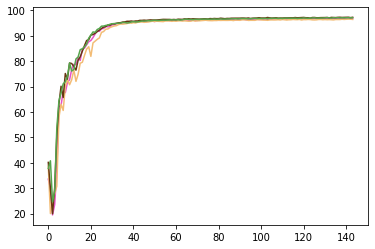

ROUND 143
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.556254
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284957
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095173

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446778
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049582
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.367802

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428691
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051728
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 144
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481799
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138120
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307409

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380570
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136830
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123862

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632149
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121225
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

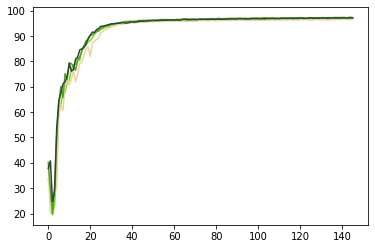

ROUND 145
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.708389
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066980
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219858

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389908
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443092
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183921

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417465
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130663
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

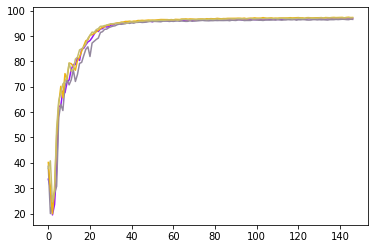

ROUND 146
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327542
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119871
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218508

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374788
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094245
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.168964

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451572
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131691
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 147
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485696
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091689
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371317

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.302191
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153128
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.684424

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496406
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032082
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 148
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489656
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168958
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372303

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.369573
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098125
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230159

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375991
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104655
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

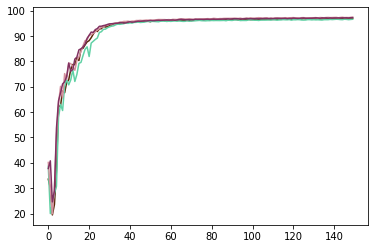

ROUND 149
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528573
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093688
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333713

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482590
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081157
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031542

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498124
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078172
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 150
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462363
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154329
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053059

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417980
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198565
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070367

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481508
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158435
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

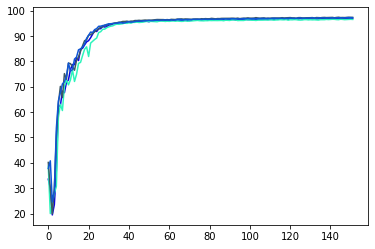

ROUND 151
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534581
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093423
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081613

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.517235
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085246
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166347

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.477273
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200145
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

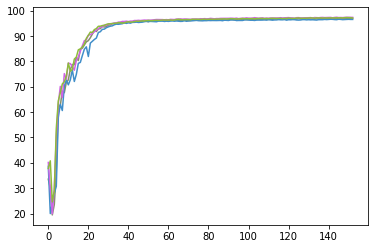

ROUND 152
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.715080
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158692
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173129

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442614
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045956
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204972

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411515
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227045
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 153
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449533
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168369
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.420855

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408727
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049857
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.505857

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396954
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190584
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

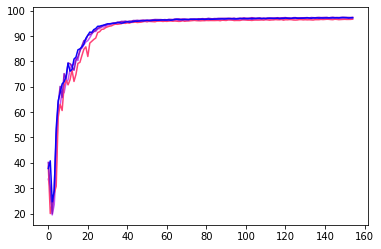

ROUND 154
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537241
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058505
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322951

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416678
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073613
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306422

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.520397
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046835
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 155
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439845
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077101
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060295

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542431
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230449
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080092

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.540994
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030324
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

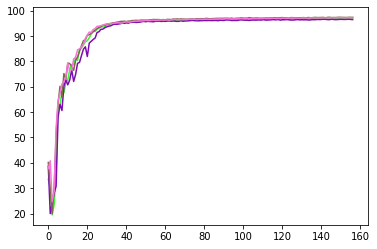

ROUND 156
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.365783
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166386
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153917

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.362094
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087936
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140196

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.429483
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030806
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

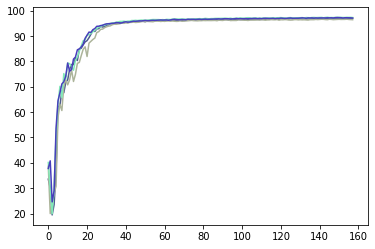

ROUND 157
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364589
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068843
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262943

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455776
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047556
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086395

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294060
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102788
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

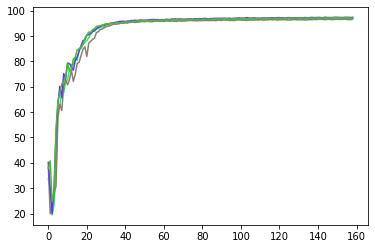

ROUND 158
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351382
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092565
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115630

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425394
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233568
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086135

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385500
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192417
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

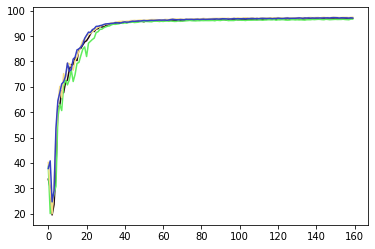

ROUND 159
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.479973
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105783
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262552

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405508
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070342
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143113

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396339
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082812
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

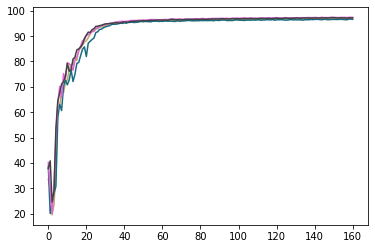

ROUND 160
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381178
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142224
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302010

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358835
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098633
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110762

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377776
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219859
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

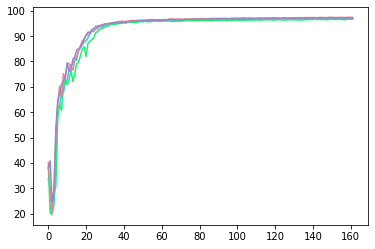

ROUND 161
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471167
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036251
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071721

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.333319
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043748
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125151

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536717
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092730
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

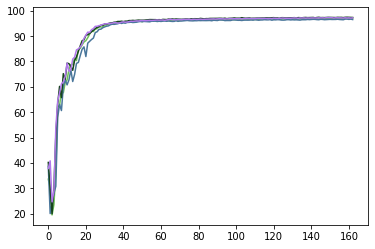

ROUND 162
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490999
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044166
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088292

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359800
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061981
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157590

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469131
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097790
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

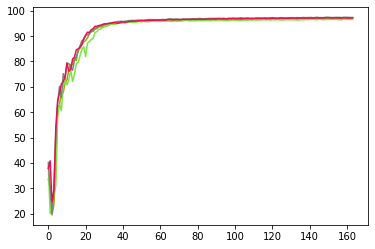

ROUND 163
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474911
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221974
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269266

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451599
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092741
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278461

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.450111
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175717
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

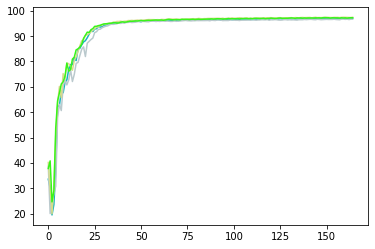

ROUND 164
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484039
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166640
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154739

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438776
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042019
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092906

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410009
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140131
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

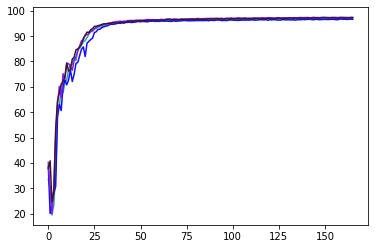

ROUND 165
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355543
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084611
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189188

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451276
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138699
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034042

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508542
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341857
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

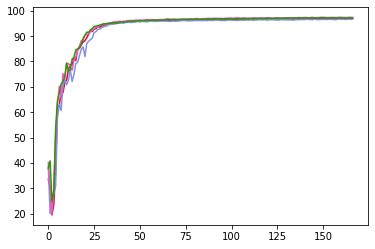

ROUND 166
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342817
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088111
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248614

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363982
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092873
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.466434

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393066
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049867
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 167
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451174
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108754
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.421396

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525284
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101885
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096388

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471112
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069285
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 168
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449076
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057175
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116760

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.414893
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061422
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159006

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446760
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137326
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

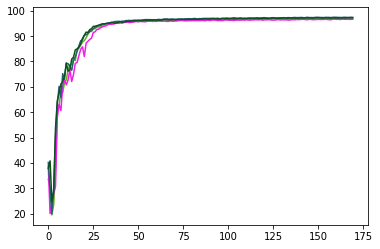

ROUND 169
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413011
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064778
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.740516

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438283
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109684
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151623

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267682
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082197
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 170
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386193
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240955
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159072

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431920
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083000
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.334042

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323581
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026298
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

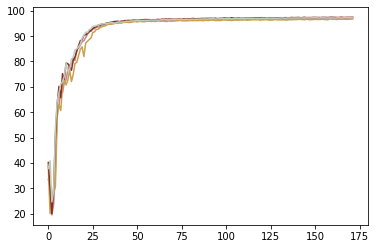

ROUND 171
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419899
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113186
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.526177

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427225
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053097
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176650

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377526
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078318
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 172
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395801
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.292871
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.758395

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390875
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066629
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068967

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405113
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303423
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

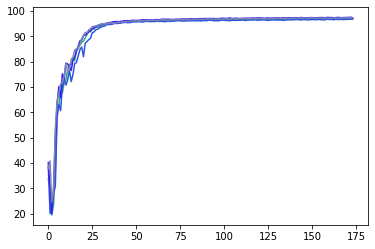

ROUND 173
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532956
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058827
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242057

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387516
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414688
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193857

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463893
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351488
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 174
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416536
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090152
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171139

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475464
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084447
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073070

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359637
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284078
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 175
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516352
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037700
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182086

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515072
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043369
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012882

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.555166
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034322
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

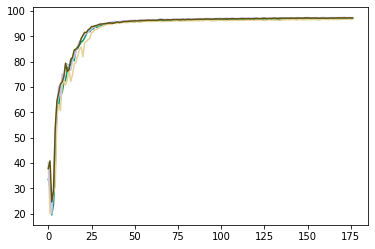

ROUND 176
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.568287
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105075
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366096

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425288
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036411
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158536

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.328136
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075932
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

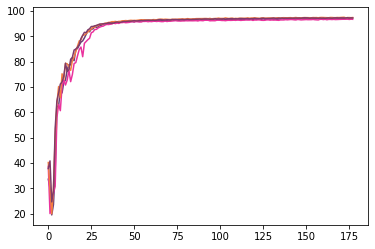

ROUND 177
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323462
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143113
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177661

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359037
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076683
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198064

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399560
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040194
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

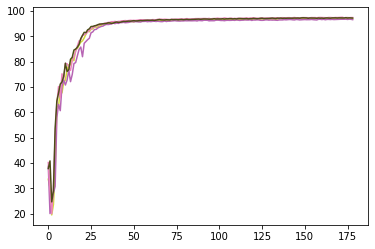

ROUND 178
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416804
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029205
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157701

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386487
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062871
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.679536

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402644
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107841
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

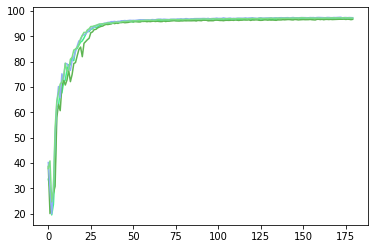

ROUND 179
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445053
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099835
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058216

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.362716
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142134
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.630985

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442661
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140849
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 180
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410972
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328863
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.467494

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380275
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047256
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449035

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337904
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071129
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

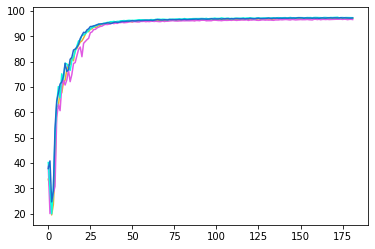

ROUND 181
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344214
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282653
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202512

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463925
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120887
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020079

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360431
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037886
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

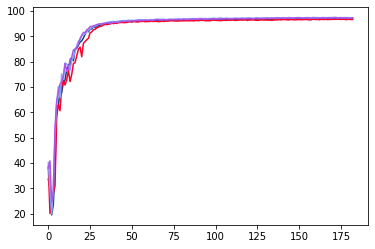

ROUND 182
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435500
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048631
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094157

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402668
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091912
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.186223

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357690
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194476
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

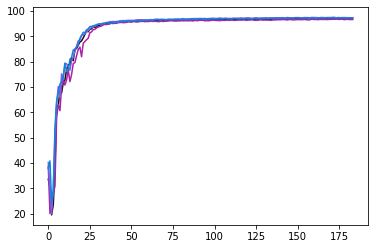

ROUND 183
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391577
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.292758
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100600

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438118
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068579
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316130

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340779
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116956
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

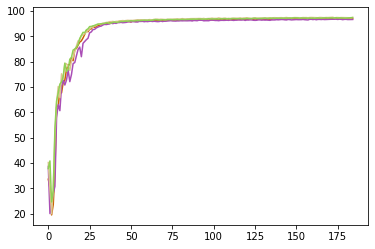

ROUND 184
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413777
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152219
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109489

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535457
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035223
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087650

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356595
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031622
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

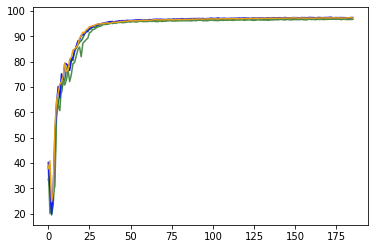

ROUND 185
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431784
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200733
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103030

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397912
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065361
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282715

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.414845
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065393
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

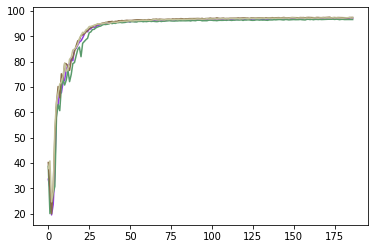

ROUND 186
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437510
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088424
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.212764

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373284
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082630
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181538

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394005
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149334
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

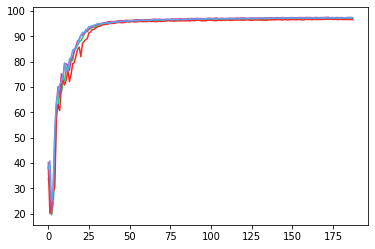

ROUND 187
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613016
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109146
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213588

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.299861
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067602
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145965

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354976
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088747
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

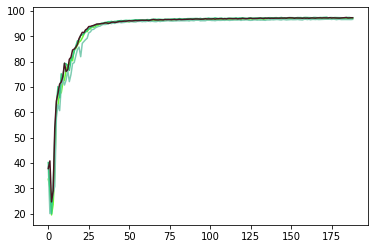

ROUND 188
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.519486
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127068
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064400

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385141
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243675
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085230

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.299655
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050320
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

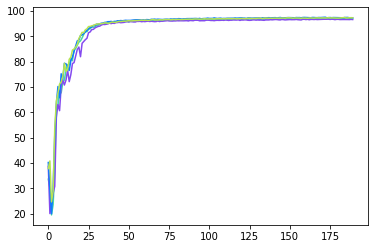

ROUND 189
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.718438
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043513
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.992955

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403133
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.208095
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.345267

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384357
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078216
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

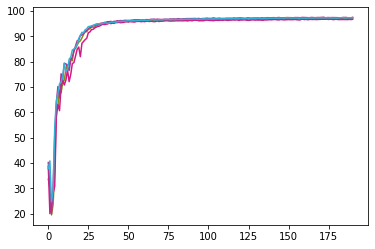

ROUND 190
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491711
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061117
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.847343

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.552530
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019355
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071961

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358901
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091583
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

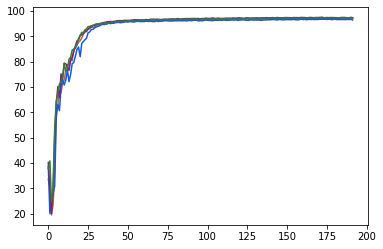

ROUND 191
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.382778
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043165
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.504682

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424889
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031259
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056568

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.349675
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081687
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

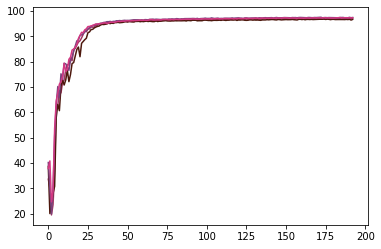

ROUND 192
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569738
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195511
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246270

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390183
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033252
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.332666

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417133
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042716
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

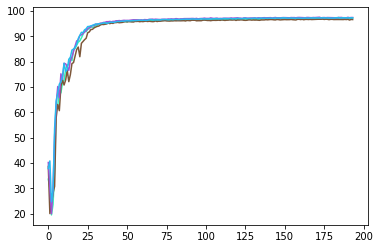

ROUND 193
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314678
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126732
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275926

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344650
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015605
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102326

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510327
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103420
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

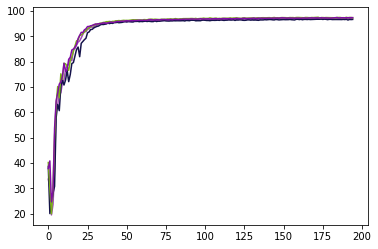

ROUND 194
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380027
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330352
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.505496

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.318393
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240796
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267088

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396079
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173250
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 195
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549785
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129067
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118296

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341847
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125371
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365088

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252838
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057352
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 196
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419565
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094285
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.638928

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350661
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013867
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077644

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434309
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135476
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

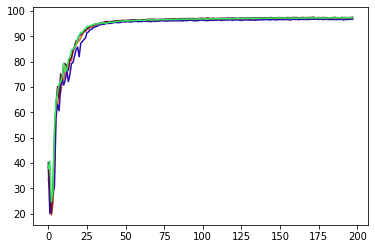

ROUND 197
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.421490
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124875
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302668

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346938
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068527
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249524

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321554
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.297552
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

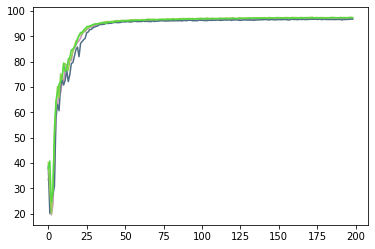

ROUND 198
0.11626000000001525
Power Allocated= 0.7124355775549001
CSI= 0.1267591788770961
SNR= 22.643655018576446
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.585789
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084335
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239446

Power Allocated= 0
CSI= 0.002224388431711577
SNR= 23.662608718497708
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.218382958358033
CSI= 0.723051331172673
SNR= 27.871997846292235
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376578
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088324
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591727

Power Allocated= 6.419402176354152
CSI= 0.45829336623967387
SNR= 33.51970098653727
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.493833
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057745
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
    
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=a cbbcbbd(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[33.58, 38.64, 40.16, 37.78], [30.02, 20.02, 29.68, 40.8], [19.49, 24.09, 19.93, 24.63], [23.56, 28.04, 30.09, 28.98], [37.12, 30.76, 50.58, 53.65], [62.11, 57.89, 63.24, 64.42], [62.59, 63.06, 70.15, 67.6], [68.3, 60.62, 65.71, 71.1], [67.63, 70.18, 75.17, 71.94], [71.69, 72.71, 72.96, 74.13], [72.71, 70.74, 79.3, 79.34], [76.8, 72.71, 79.1, 76.11], [78.76, 76.62, 77.93, 76.79], [78.71, 72.07, 76.5, 80.9], [81.37, 74.86, 80.36, 81.67], [80.32, 79.21, 81.78, 84.55], [84.8, 79.59, 84.0, 84.92], [85.15, 82.27, 86.12, 85.66], [86.48, 84.76, 88.14, 86.78], [87.67, 85.72, 88.5, 89.09], [88.17, 81.91, 90.29, 90.27], [89.32, 87.19, 90.51, 91.53], [90.74, 87.93, 91.01, 91.41], [92.11, 88.62, 91.64, 92.5], [91.76, 89.18, 92.31, 92.92], [92.79, 91.36, 92.91, 93.81], [92.88, 91.69, 93.44, 93.85], [93.79, 92.62, 93.61, 94.1], [93.52, 92.7, 94.27, 94.22], [93.64, 93.26, 94.18, 94.56], [94.33, 93.6, 94.75, 94.76], [94.32, 93.86, 94.7, 94.85], [94.82, 94.0, 94.92, 94.9], [94.92, 94.42, 95.12, 94.98]